<a href="https://colab.research.google.com/github/kap2fox/Intro-to-Robotics/blob/main/eng_PID_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PID with Python
This section is devoted to modeling engine operation when adding control laws. At each step of the program operation, just as in a real robot, the control voltage is calculated. How to calculate the control voltage is an extremely broad question that is addressed by automatic control theory. The basic control algorithm is the proportional-integral-derivative controller, or PID controller. Its software implementation is discussed below.

In [1]:
import numpy as np                            # array module
import matplotlib.pyplot as plt               # vizualization
from scipy.integrate import odeint            # numerical ODE solver

First, we need to define the engine model parameters. Last time we used time values recorded in a file. This time we'll need to define the time space ourselves. The *linspace* function from the *numpy* module is suitable for this purpose.

In [2]:
T_m = 0.08                                   # electromechanical time constant
k_e = 0.5                                    # torque constant
n = 5001                                     # modeling samples
t = np.linspace(0,5,n)                       # timeline

Next, it is necessary to define the motor model by analogy with the previous lecture using system of equations 5, with the difference that now the control voltage value will be passed to the model at each simulation step:
$$
\left\{
    \begin{array}\\
        \dot\omega=\frac{U}{T_m k_e}-\frac{\omega}{T_m}, \\
        \dot\theta=\omega.
    \end{array} \tag{5}
\right.
$$

In [3]:
def motor(state,t,u):
    speed, angle = state                                # обозначение состояния двигателя как скорости и угла поворота
    state_dt = [-speed/T_m + u/ (T_m * k_e), speed ]    # задание производной состояния двигателя
    return state_dt

For modeling the operation of a PID controller, it will be necessary to define variables and arrays of controller values. In order to be able to examine the behavior of each of the controller components, arrays of zeros need to be created for each of them using the *zeros* function.

In [4]:
Kp = 1                                                   # proportional coefficient
Ki = 0.3                                                 # integral coefficient
Kd = 0.2                                                 # differential coefficient
P= np.zeros(n)                                           # proportional part
I = np.zeros(n)                                          # integral part
D = np.zeros(n)                                          # dufferential part
e = np.zeros(n)                                          # error array
u = np.zeros(n)                                          # control power
theta = np.zeros(n)                                      # angle array
r = np.zeros(n)                                          # desired angle
r[0:n] = 5                                               # 5 radian desired angle
init = [0 , 0]                                           # Initial conditions

Now we need to create a loop for the number of simulation steps and calculate the motor state values ​​at each iteration. For this, we'll use the *odeint* function, but we'll only simulate one step *(t[i-1],t[i])*. Each step will start from the previous non-zero initial conditions *init* and take into account the current control voltage *u*.

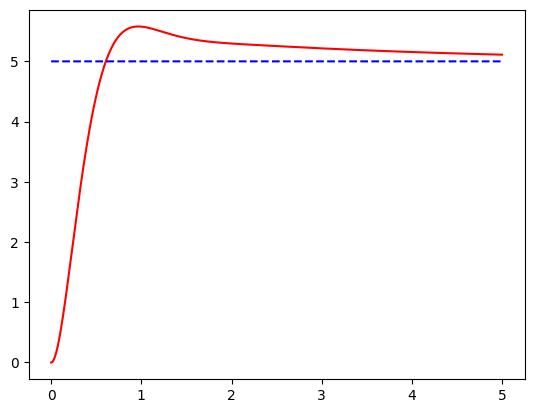

In [5]:
for i in range(1,n):
    ts = [t[i-1],t[i]]                                   # modeling time
    y = odeint(motor,init,ts,args=(u[i-1],))             # rotation angle and speed
    #odeint return two values in a time t[i-1] и t[i]
    init = y[1,:]                                        # save the last value of angle
    theta[i] = y[1,1]                                    # current angle
    e[i] = r[i] - theta[i]                               # error calculation
    dt = t[i] - t[i-1]                                   # time calculation
    P[i] = Kp * e[i]                                     # proportional part
    I[i] = I[i-1] + Ki * e[i] * dt                       # integral part with Euler method
    D[i] = Kd * (theta[i]-theta[i-1])/dt                 # differential part with finite difference method
    u[i] = P[i] + I[i] + D[i]                            # power calculation
    if u[i] > 8:
            u[i] = 8
    if u[i] < -8:
            u[i] = -8                                    # limit power maximum voltage

plt.plot(t, theta,'r-')                                  # plot graph
plt.plot(t, r,'b--')                                     # vizualization